<img src="img/bigsem.png" width="40%" align="right">
<img src="img/logo_wiwi.png" width="20%" align="left">





<br><br><br><br>

# Dynamic Programming Models in Combinatorial Optimization
**Winter Term 2024/25**


# 4. DP Models within MIP Formulations II: State-Expanded Networks
<img src="img/decision_analytics_logo.png" width="17%" align="right">


<br>

<br>
<br>

**J-Prof. Dr. Michael Römer |  Decision Analytics Group**
                                                    


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit, typeof
from typing import NamedTuple, Callable, Any
from dataclasses import dataclass, field
from numba.experimental import jitclass
import networkx as nx
from collections import deque
import gurobipy as gp
from gurobipy import GRB


# Overview
- DP Models / DDs as basis of flow-based MIPs
  - example: Knapsack Problem
- The Multiple Knapsack Problem
  - standard MIP model
  - as DP Model
  - as DP model with multiple flow units


## Example: the 0/1 knapsack problem

Given 
- a knapsack with a capacity $W$ 
- and a set of items, each with a weight $w_i$ and a value $p_i$
- determine the the subset of the items to put in the knapsack such that
  - the total value of the items in the knapsack is maximal and
  - the total weight of the items in the knapsack does not exceed $W$

**Example:**

<img src="./img/greedy/07.png" width="20%" align="right">

Assume you are a thief and you are about to steal the three items depicted below from an appartment. However, your backpack can only fit 35 lbs. Which items should you take?



<img src="./img/greedy/08.png" width="40%" align="left ">

In [2]:
class DP(NamedTuple):
    feasible_decisions : Callable
    transition_function : Callable
    cost_function : Callable
    direction : str # 'max' or 'min'

## Generic helper functions to deal with maximization and minimization

In [3]:
@njit 
def better(value1, value2, direction):
    if direction == "min":
        return value1 < value2
    else:
        return value1 > value2

In [4]:
@njit
def best_element_and_value(elements, values, direction):
    if direction == "min":
        best_index = np.argmin(values)
    else:
        best_index = np.argmax(values)
    return elements[best_index], values[best_index]

In [5]:
@njit
def get_n_best_elements_and_values(n, elements, values, direction):
    
    if direction == "min":
        sorted_indexes = np.argsort(values)
    else:
        sorted_indexes = np.argsort(-values)
    return elements[sorted_indexes[:n]], values[sorted_indexes[:n]]


In [6]:
get_n_best_elements_and_values(2, np.array([1,2,3]), np.array([2,3,5]), 'min')

(array([1, 2]), array([2, 3]))

## Example: A DP model for the Knapsack Problem
- given a  knapsack instance with $N$ items with weights $w_k$ and profits $p_k$ (zero-indexed) and capacity $W$ 

- state $x_k$: accumulated weight after adding the first $k-1$ items, $x_0 = 0$
- decision $u_k \in \{0, 1\}$ (0: do not add item $k$ to the knapsack; 1: add item $k$)
- $U_k(x_k) = \begin{cases} 
                \{0,1\} \quad \mathrm{if} \quad x_k + w_k \leq W \\
                \{0 \} \quad \mathrm{else}
\end{cases}$

- $f(x_k, u_k) = x_k + w_k u_k $

- $g(x_k, u_k) = p_k u_k$

We have a maximization-objective:

$$\max_{u_0,..,u_k,..u_{N-1}} \sum_{k=0}^{N-1} g_k(x_k,u_k)$$

## The Knapsack DP Model in Python

In [7]:
class  KPInstance(NamedTuple):
    values:np.array
    weights:np.array
    capacity:int
    N:int   

@njit
def feasible_decisions_kp(instance, k, acc_weight):    
    if acc_weight + instance.weights[k] <= instance.capacity: return np.array([0,1])
    else: return np.array([0])

@njit
def transition_function_kp(instance, k, acc_weight, put):
    return acc_weight + put*instance.weights[k]

@njit
def cost_function_kp(instance, k, acc_weight, put):
      return put*instance.values[k]

Putting all together, and stating that we have a maximization objective

In [8]:
dp_kp = DP(feasible_decisions_kp, transition_function_kp,  cost_function_kp, "max")

## An instance reader function for the Knapsack Problem

In [9]:

def read_kp_instance(filename, sorted=True):
    weights=[]
    values=[]
    with open(filename) as f: # open the file
        line = f.readline().split()  # split first row
        number_of_items = int(line[0]) # read number of items
        capacity = int(line[1]) # read capacity
        for i in range(number_of_items): # read rows for the items
            line = f.readline().split() # split row
            values.append(int(line[0])) # read value
            weights.append(int(line[1])) # read weight
            
    values = np.array(values)
    weights = np.array(weights)    
    
    
    if sorted:
        sorted_indexes = np.argsort(-1* values/weights)
    values = values[sorted_indexes]
    weights = weights[sorted_indexes]
     
        
    return KPInstance(values, weights, capacity, number_of_items)



In [10]:
#filename = "./../problems/knapsack/instances/knapPI_1_5000_1000_1"
filename = "./../problems/knapsack/instances/knapPI_1_100_1000_1"
kp_instance = read_kp_instance(filename)

## Exact Decision Diagrams

- given a DP model, we can view an exact DD as a state-transition-graph, with one exception:
  - we introduce a terminal node that forms the target of all arcs emanating from layer $N-1$
- just as in the DP by reaching algorithm, we can construct the exact DD by 


## A Decision Diagram data structure

We will introduce a class `DecisionDiagram` that represents a DD
- consisting of $N$ + 1 layers indexed from 0 to $N$
    - each layer is a dictionary where the key is a state and the value is a `NodeInfo` object
  - (problem-specific) state values representing the start (source) state and the sink state
  

In [11]:


class DecisionDiagram:        
    def __init__(self, number_of_layers, source_layer, source_state, sink_state, direction = 'max'):
        self.g = nx.MultiDiGraph()
        self.number_of_layers = number_of_layers
        self.layers = [set() for l in range(0, number_of_layers)]
        self.source_state = source_state
        self.sink_state = sink_state
        self.layers[source_layer].add(source_state)
        self.g.add_node((source_layer, source_state), best_dist = 0, best_in_edge = None)
        self.direction = direction
        self.last_exact_layer = source_layer
        



        
        
        
        
        
        

## Building an exact DD by top-down-compilation
- building an exact DD is basically the same as building the DP by reaching: states are "discovered" layer per layer
- by applying the transition function to each feasible decision in each state in the layer under consideration
- in the following algorithm, we store the best distance from the source / root node as well as the preceding node in each node
- this means that the best path in the DD is computed "in passing"

## Building an exact DD by top-down-compilation in Python
- observe: here, we introduce a sink state as a "dummy" state (that is otherwise not reachable)

In [12]:
def build_exact_dd(dp, instance, start_layer, start_state, sink_state):
    
    dd = DecisionDiagram(instance.N+1, start_layer, start_state, sink_state, dp.direction)
    
    state = start_state
    total_cost = 0
    
    for k in range(0,instance.N):
        
        for state in dd.layers[k]:
            decisions = dp.feasible_decisions(instance, k, state)
            
            for decision in decisions:
                if k < instance.N -1: # if we are the final layer, point to the "sink state"
                    next_state = dp.transition_function(instance,k,state, decision)
                else:
                    next_state = sink_state
                
                add_transition_dd(dd, k, state, decision, next_state, dp.cost_function(instance, k, state, decision))
   
    k = instance.N-1
    
    return dd

## Creating new nodes: adding the result of a transition

In [13]:
def add_transition_dd(dd, layer_index, state, decision, result_state, cost):
    
    layer = dd.layers[layer_index]
    result_layer = dd.layers[layer_index+1] 
    
    node = (layer_index, state)
    
    result_node = (layer_index+1, result_state)
 
    result_dist = dd.g.nodes[node]["best_dist"] + cost  

    if result_state not in result_layer:
        result_layer.add(result_state)
        dd.g.add_node(result_node, best_dist=result_dist, best_in_edge=(node,result_node,decision))
        
    elif better(result_dist, dd.g.nodes[result_node]["best_dist"], dd.direction): 
        dd.g.nodes[result_node]["best_dist"] = result_dist
        dd.g.nodes[result_node]["best_in_edge"]=(node,result_node,decision)
    
    dd.g.add_edge(node, result_node, decision, cost=cost)


## Trying it out, and some utility functions:

In [14]:
dd = build_exact_dd(dp_kp, kp_instance, 0, 0,-1)


..getting the best objective

In [15]:
def get_best_objective (dd):
    return dd.g.nodes[(dd.number_of_layers-1,dd.sink_state)]["best_dist"]

In [16]:
get_best_objective (dd)

9147

..getting the best path

In [17]:

def get_best_path(dd):
    
    decisions = []
    
    state =  dd.sink_state
    k = dd.number_of_layers - 1
        
    while k > 0:
       # print(k)
        node,  next_node, decision = dd.g.nodes[(k,state)]["best_in_edge"]
        #print (dd.layers[k+1])
        decisions.append(decision)
        k, state = node
        
        

    return  dd.g.nodes[(dd.number_of_layers-1,dd.sink_state)]["best_dist"], list(reversed(decisions))


In [18]:
get_best_path(dd)[1][:10] ## first 10 nodes

[np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1)]

..getting the number of nodes

In [19]:
def get_number_of_nodes(dd):
    return dd.g.number_of_nodes()


In [20]:
get_number_of_nodes(dd)

80725

## Reducing an exact DD

One of the key ideas from DDs is that very often, a DD can be compressed / reduced by merging nodes 
that 
- do not have identical (top-down) states
- but are nonetheless **equivalent** in the sense that they have the same *completions*, that is, the same set of partial solutions until the end (the solution sets of their tail subproblems are identical)

This type of equivalence can be identified by an upward-pass starting from the bottom layer $N$ to layer $0$

- in each layer $k$, two nodes are equivalent (are in the same equivalence class) if 
  - they have the same set of feasible decisions 
  - these decisions have the same costs
  - the corresponding arcs point to the same set of nodes in the subsequent layer $k+1$
- for each equivalence class, merge all nodes in that class into a single node

**Attention:** The following implementation assumes that the decision costs are state-independent. If the decision costs (the arc costs) are state-dependent, then we need to add a check for identical costs, too

## Implementing the DD reduction

In [21]:
def reduce_exact_dd(dd):
    
    #proceed from the bottom (last layer) to the top
    k = len(dd.layers)-1
    while k > 0:
        
        # a dict with key: decisions and resulting nodes (forming an equivalence class)
        #       and value: list of states falling into that class
        eq_classes = {}
    
        #1. collect equivalence classes and states/nodes in each class
        for state in dd.layers[k]:
            
            out_arc_info = []
            
            for u,v,decision,data in dd.g.out_edges((k,state),keys=True, data=True):
                out_arc_info.append((decision,v,data["cost"]))
                
            eq_class = tuple(sorted(out_arc_info))
            
            if eq_class not in eq_classes:
                eq_classes[eq_class] = [state]                
            else:
                eq_classes[eq_class].append(state)
        
        # 2. merge all states in each class into a single node
        for eq_class, states in eq_classes.items():            
            while len(states) > 1:
                state_remove = states.pop()
                merge_nodes(dd, k, states[0], state_remove)
                
        k=k-1

## Merging two nodes

In [22]:
def merge_nodes(dd, layer_index, state_orig, state_remove):
    
    node_orig = (layer_index, state_orig)
    node_remove = (layer_index, state_remove)
    
    layer = dd.layers[layer_index]

    

    # 1. Keep the best distance to from the source
    if better(dd.g.nodes[node_remove]["best_dist"], dd.g.nodes[node_orig]["best_dist"], dd.direction):        
        (u,v,d) = dd.g.nodes[node_remove]["best_in_edge"]
        dd.g.nodes[node_orig]["best_in_edge"] = (u,node_orig,d)
        dd.g.nodes[node_orig]["best_dist"] = dd.g.nodes[node_remove]["best_dist"]

    
    # update best stuff
    
    for u, v, decision,data in dd.g.out_edges(node_remove, keys=True, data=True):
        if dd.g.nodes[v]["best_in_edge"] == (u,v,decision):
            dd.g.nodes[v]["best_in_edge"] = (node_orig, decision, v)
            

    # 3. redirect the in-arcs from the removed node to the node to be kept
    
    arcs_to_add = []
    for u,v,decision,data in dd.g.in_edges(node_remove, keys = True, data=True):
        arcs_to_add.append((u,node_orig, decision, data))
                           
    dd.g.remove_node(node_remove)
    layer.remove(state_remove)
    
    dd.g.add_edges_from(arcs_to_add)


## Trying it  out

In [23]:
reduce_exact_dd(dd)

print ("reduced nodes", get_number_of_nodes(dd))

reduced nodes 19957


# DP Models within MIPs




## Observation:  DDs and optimal paths

- instead of computing the optimal path "on the fly", we could simply compute the longest path in the DD from the source to the sink (terminal node)
- since we have a directed acyclic graph, this can even be done in linear time
- we can simply use the function `dag_longest_path_length` from NetworkX


In [24]:
%%time
dd = build_exact_dd(dp_kp, kp_instance, 0, 0,-1)

CPU times: total: 1.77 s
Wall time: 1.75 s


In [25]:
%time
nx.dag_longest_path_length(dd.g, weight="cost")

#reduce_exact_dd(dd)

CPU times: total: 0 ns
Wall time: 0 ns


9147

### Optimal Paths using a MIP solver

- as you may know, instead of calling a shortest path algorithm we may just formulate the shortest path problem as a **min-cost-flow problem** that can can, in turn, be solved by a MIP

The mathematical model would look as follows (assuming that we have a circulation arc $e^\mathrm{circ}$ from source to sink node):

- let the graph be defined as $G(N,E)$
- let us denote the flow variables with $x$ (we're back in the MIP world ;-))


$$\min \sum_{e \in E}c_e x_e$$

s.t.
$$
 \sum_{e \in v^-} x_e = \sum_{e \in v^+} x_e \quad \forall v \in N \\
 x_e^\mathrm{circ} = 1 \\
 x_e \in \{0, 1\} \quad \forall e \in E $$

In [26]:
def build_network_flow_component(m, dd, flow_size = 1):    
    
    ## add flow vars    
    edge_to_flow_var = {}  

    for e, data in dd.g.edges.items():
            edge_to_flow_var[e] = m.addVar(vtype=GRB.INTEGER, obj = data["cost"] )
    
    ## if not existing yet, add circulation arc
    if dd.g.out_degree ( (dd.number_of_layers-1, dd.sink_state) ) == 0:  
        dd.g.add_edge( (dd.number_of_layers-1, dd.sink_state),  (0, dd.source_state), key=-1, cost=0)      

    ## add flow var for circulation arc and fix flow
    edge_to_flow_var[((dd.number_of_layers-1, dd.sink_state),  (0, dd.source_state), -1)] = m.addVar(vtype=GRB.INTEGER, lb=flow_size, ub=flow_size)
    
    ## add flow balance constraints
            
    for v in dd.g.nodes():
        m.addConstr(gp.quicksum(edge_to_flow_var[e] for e in dd.g.in_edges(v,keys=True)) == gp.quicksum(edge_to_flow_var[e] for e in dd.g.out_edges(v, keys=True) ))

    return edge_to_flow_var
            
        
    
    

## Optimal Paths using a MIP solver: Trying it Out

Read instance


In [27]:

filename = "./../problems/knapsack/instances/knapPI_1_100_1000_1"
kp_instance = read_kp_instance(filename)

Build DD

In [28]:
dd = build_exact_dd(dp_kp, kp_instance, 0, 0,-1)
get_number_of_nodes(dd)

80725

Build MIP model

In [29]:

m = gp.Model("knapsack_dd")
m.ModelSense = GRB.MAXIMIZE
edge_to_flow_var = build_network_flow_component(m, dd)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-20


Solve it

In [30]:
%%time
m.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 80725 rows, 112812 columns and 225624 nonzeros
Model fingerprint: 0x1b40e880
Variable types: 0 continuous, 112812 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 74853 rows and 94905 columns
Presolve time: 0.36s
Presolved: 5872 rows, 17907 columns, 35814 nonzeros
Variable types: 0 continuous, 17907 integer (9860 binary)
Found heuristic solution: objective 2869.0000000
Found heuristic solution: objective 3367.0000000
Found heuristic solution: objective 9147.0000000
Performing another presolve...
Presolve removed 5872 rows and 17907 columns
Presolve time: 0.09s

Explored 1 node

In [31]:
print(m.ObjVal)

9147.0


## Extracting the solution

- to get the solution path, we can just "follow" the flow variables with value 1:

In [32]:
def get_solution_path(edge_to_flow_var, dd):
    
    decisions = []
    
    
    node = (0, dd.source_state)    
    while node[1] != dd.sink_state:
        for node, target_node, decision in dd.g.out_edges(node, keys=True):
            if edge_to_flow_var[node, target_node, decision].x > 0.1:
                decisions.append(decision)                
                node = target_node
                break
                
    return decisions     
 
decisions = get_solution_path(edge_to_flow_var, dd)
decisions[:10]

[np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1)]

- we can then turn this into a "readable solution"

In [33]:
def get_items_from_path(decisions):
    solution_items =  []
    for i, dec in enumerate(decisions):
        if dec == 1:
            solution_items.append(i)
            
    return solution_items

In [34]:
get_items_from_path(decisions)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13]

## Of course, we can benefit from the DD reduction!

In [35]:
reduce_exact_dd(dd)

In [36]:
get_number_of_nodes(dd)

19957

..once again, building and solving the model:

In [37]:

m = gp.Model("knapsack_dd")
m.ModelSense = GRB.MAXIMIZE

edge_to_flow_var = build_network_flow_component(m, dd)

In [38]:
%%time
m.optimize()



Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 19957 rows, 36235 columns and 72468 nonzeros
Model fingerprint: 0x1dc41a19
Variable types: 0 continuous, 36235 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 19957 rows and 36235 columns
Presolve time: 0.19s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.27 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 9147 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.147000000000e+03, best bound 9.147000000000e+03, gap 0.0000%
CPU times: total: 219 ms
Wall time: 219 ms


## An Observation for the 0/1 KP Model

- let us re-examine the size of the DD before and after the reduction

In [39]:

filename = "./../problems/knapsack/instances/knapPI_1_100_1000_1"
kp_instance = read_kp_instance(filename)
dd = build_exact_dd(dp_kp, kp_instance, 0, 0,-1)
print("nodes before reduction", get_number_of_nodes(dd))
reduce_exact_dd(dd)
print("nodes after reduction", get_number_of_nodes(dd))

nodes before reduction 80725
nodes after reduction 19957


**Remember:** when reading the instance, we sorted the items according to value/weight, because this yielded the best result for the greedy heuristic

- when creating an exact DD, is this still the best sorting / variable ordering?

- turns out not: it is much better to sort according to weight in descending order since this leads to a **smaller** network!

In [40]:
sorted_indexes = np.argsort(-1* kp_instance.weights)
kp_instance = KPInstance(kp_instance.values[sorted_indexes], kp_instance.weights[sorted_indexes], kp_instance.capacity, kp_instance.N)

print (kp_instance.N)

100


In [41]:
dd = build_exact_dd(dp_kp, kp_instance, 0, 0,-1)
print("nodes before reduction", get_number_of_nodes(dd))
reduce_exact_dd(dd)
print("nodes after reduction", get_number_of_nodes(dd))

nodes before reduction 21618
nodes after reduction 12218


## Is this any better than a standard MIP model?

The standard MIP formulation for the 0/1 KP looks as follows:
- let $I$ be the set of items, and $W$ be the capacity


$$\max \sum_{i \in I}p_i x_i$$

s.t.
$$
 \sum_{i \in I} x_i \leq W \\
 x_i \in \{0, 1\} \quad \forall i \in I $$



##  In Python

In [42]:
m = gp.Model("knapsack")

m.ModelSense = GRB.MAXIMIZE

x = [m.addVar(vtype=GRB.BINARY) for i in range(kp_instance.N)]


m.setObjective(gp.quicksum(kp_instance.values[i] * x[i] for i in range(kp_instance.N)))

m.addConstr(gp.quicksum(kp_instance.weights[i] * x[i] for i in range(kp_instance.N)) <= kp_instance.capacity)

<gurobi.Constr *Awaiting Model Update*>

In [43]:
%%time
m.optimize()
print(m.objVal)
selected = [i for i in range(kp_instance.N) if x[i].x >= 0.99]
print("selected items: {}".format(selected))


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 100 columns and 100 nonzeros
Model fingerprint: 0xfaca8c5c
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [9e+00, 1e+03]
  Objective range  [7e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+03]
Found heuristic solution: objective 794.0000000
Presolve removed 1 rows and 100 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 9147 794 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.147000000000e+03, best bound 9.147000000000e+03, gap 0.0000%
9147.0
selected items: [7

.. this was not a big success for DD, acutually... let's see what comes next

## The Multiple Knapsack Problem

- the multiple knapsack problem is an extension of the 0/1 KP where we do not have a single, but multiple knapsacks
- in general, the knapsacks can have different capacities
- **but here**, for the sake of simplicity, we assume that all knapsacks have the same capacity

..let us first define an instance type

In [44]:
class  MKPInstance(NamedTuple):
    values:np.array
    weights:np.array
    capacity:int
    number_of_knapsacks:int
    N:int
        

..and an instance creation function that uses the KP instance format to create an MKP instance 

In [45]:
       
def create_mkp_instance_from_kp(kp_instance, number_of_knapsacks, weight_factor = 0.5):
    
    cap = int(weight_factor *np.sum(kp_instance.weights) / number_of_knapsacks)    
        
    return MKPInstance(kp_instance.values, kp_instance.weights, cap, number_of_knapsacks, kp_instance.N)

In [46]:
mkp_instance = create_mkp_instance_from_kp(kp_instance, 20)

## The Multiple Knapsack Problem: Standard MIP formulation


- let $I$ be the set of items, let $J$ be the set of knapsacks and $W$ be the capacity
- once again, we assume here (as opposed to standard MKP) that $W$ is the same for all $j \in J$


$$\max \sum_{i \in I}\sum_{j \in j}  p_i x_{ij} $$

s.t.
$$
 \sum_{i \in I} x_{ij} \leq W  \quad \forall j \in J \\
  \sum_{j \in J} x_{ij} \leq 1  \quad \forall i \in I \\
 x_{ij} \in \{0, 1\} \quad \forall i \in I, j \in J $$

## The Multiple Knapsack Problem: Solving the standard MIP formulation in Python



In [47]:
m = gp.Model("multiple_knapsack")


x = [[m.addVar(vtype=GRB.BINARY) for k in range(mkp_instance.number_of_knapsacks)] for i in range(mkp_instance.N)]


m.ModelSense = GRB.MAXIMIZE

m.setObjective (gp.quicksum(mkp_instance.values[i] * x[i][k] for i in range(mkp_instance.N)  for k in range(mkp_instance.number_of_knapsacks) ))

for k in range(mkp_instance.number_of_knapsacks):
    
    m.addConstr(gp.quicksum(mkp_instance.weights[i] * x[i][k] for i in range(mkp_instance.N)) <= mkp_instance.capacity)
    
for i in range(mkp_instance.N):
        m.addConstr(gp.quicksum(x[i][k] for k in range(mkp_instance.number_of_knapsacks)) <= 1)

..solving it

In [48]:
%%time

m.params.TimeLimit = 2*60 #just to make sure, we'r in class!

#m.optimize()

Set parameter TimeLimit to value 120
CPU times: total: 0 ns
Wall time: 0 ns


In [49]:
#print("objective", m.ObjVal, "upper bound", m.ObjBound, f"gap %  {100*(m.ObjBound - m.ObjVal) / m.ObjVal:0.3f}")

## A DP Model for the MKP?

How would a DP model look like for the MKP?

You can use this 0/1 KP model as starting point:

- state $x_k$: accumulated weight after adding the first $k-1$ items, $x_0 = 0$
- decision $u_k \in \{0, 1\}$ (0: do not add item $k$ to the knapsack; 1: add item $k$)
- $U_k(x_k) = \begin{cases} 
                \{0,1\} \quad \mathrm{if} \quad x_k + w_k \leq W \\
                \{0 \} \quad \mathrm{else}
\end{cases}$

- $f(x_k, u_k) = x_k + w_k u_k $

- $g(x_k, u_k) = p_k u_k$

We have a maximization-objective:

$$\max_{u_0,..,u_k,..u_{N-1}} \sum_{k=0}^{N-1} g_k(x_k,u_k)$$

## DP Model for the MKP: In Python

In [50]:
@njit
def feasible_decisions_mkp(instance, k, acc_weight):    
    #if acc_weight + instance.weights[k] <= instance.capacity: return np.array([0,1])
    #else: return np.array([0])
    return

@njit
def transition_function_mkp(instance, k, acc_weight, put):
    #return acc_weight + put*instance.weights[k]
    return

@njit
def cost_function_mkp(instance, k, acc_weight, put):
      #return put*instance.values[k]
    return

In [51]:
dp_mkp = DP(feasible_decisions_mkp, transition_function_mkp,  cost_function_mkp, "max")

In [52]:
N = 20
kp_instance_small = KPInstance(kp_instance.values[:N], kp_instance.weights[:N],kp_instance.capacity,  N)
mkp_instance_small = create_mkp_instance_from_kp(kp_instance_small, 4)

In [53]:
#start_state = 
# sink_state
#dd = build_exact_dd(dp_mkp, mkp_instance_small, 0, start_state, sink_state)

## Key idea: Multiple flow units through a single-knapsack DD


**Observe the following:**
- in the MKP that we consider here (identical capacities), the set of feasible solutions for each knapsack with capacity $W$ is identical to the set of solutions of a single 0/1-KP with capactiy $W$
- each item can only be assigned to a **single knapsack**

Now let us dicuss a **key idea** useful in many cases, not only for 0/1 KP:
- if we are looking for a solution that can be represented as a set of multiple paths within the same network
  - **we can model this as a (multi-unit) flow through a single network**
  - that can be modeled as part of a MIP model#
  - which gives us the opportunity to add **additional constraints** not represented in the network
  

- after solving such a model, we can obtain feasible solutions via **flow decomposition**

## Formulating the MKP using a DD-based flow component

- let $I$ be the set of items, let $J$ be the set of knapsacks and $W$ be the capacity
-  we assume here (as opposed to standard MKP) that $W$ is the same for all $j \in J$

- assume that we have a graph $G=(V,E)$ that is the graph underlying a DD, augmented with a flow circulation arc $e^\mathrm{circ}$

- let $E^i$ be the set of items representing the set edges picking item $i$

Then, we can formulate the MKP as follows:

$$\min \sum_{e \in E} c_e x_e$$

s.t.
$$
 \sum_{e \in v^-} x_e = \sum_{e \in v^+} x_e \quad \forall v \in N \\
 x_e^\mathrm{circ} = |J| \\ 
 \sum_{e \in E^i} x_e \leq 1 \quad \forall i \in I \\ 
 x_e \in \{0, 1\} \quad \forall e \in E $$

..what is "surprising" / different to the standard MKP formulation here?

## Formulating the MKP using a DD-based flow component: In Python
..building reduced DD

In [54]:
dd = build_exact_dd(dp_kp, mkp_instance, 0, 0,-1)
print ("nodes before reduction", get_number_of_nodes(dd))
reduce_exact_dd(dd)
print ("nodes after reduction", get_number_of_nodes(dd))

nodes before reduction 33696
nodes after reduction 20262


..creating the model

In [55]:
m = gp.Model("mk_knapsack_dd")

m.ModelSense = GRB.MAXIMIZE

# network flow component
edge_to_flow_var = build_network_flow_component(m, dd, mkp_instance.number_of_knapsacks)

# create the sets of edges per item
item_variables = [[] for i in range(mkp_instance.N)]
for e, var in edge_to_flow_var.items():    
    if e[2]==1:
        item_variables[e[0][0]].append(var)        

# create the constraints forcing every item to be picked at most onces     
for i, item_vars in enumerate(item_variables): 
    m.addConstr(gp.quicksum(item_var for item_var in item_vars)  <= 1 )                    

..solving the model

In [56]:
%%time
m.params.TimeLimit = 2*60
m.optimize()

print("objective", m.ObjVal, "upper bound", m.ObjBound, f"gap %  {100*(m.ObjBound - m.ObjVal) / m.ObjVal:0.3f}")

Set parameter TimeLimit to value 120
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  120

Optimize a model with 20362 rows, 34325 columns and 82713 nonzeros
Model fingerprint: 0x9b34cb44
Variable types: 0 continuous, 34325 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+03]
  Bounds range     [2e+01, 2e+01]
  RHS range        [1e+00, 1e+00]
Presolve removed 11926 rows and 11885 columns
Presolve time: 0.40s
Presolved: 8436 rows, 22440 columns, 59189 nonzeros
Variable types: 0 continuous, 22440 integer (14492 binary)
Found heuristic solution: objective 29853.000000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   28997    4.0423331e+04   1.338744e+02   0.00000

## Obtaining Paths via Flow Decomposition
.. now let us see how to obtain the solution for each of the knapsacks:
- the core idea here is to "walk through the DD" from source to sink $|J|$ times
- we start by initiating a dict stores the remaining flow through each edge
  - initialized by the flow solution
- then we extract one path by following a "non-zero" path from source to sink, reducing the remaining flow on each visited edge
- until there is no more flow

**Observe:**

In general, such a flow decomposition is not unique!


In [57]:
def decompose_flow_to_solution_paths(edge_to_flow_var, dd):
    
    paths = []
    
    ## inoit    
    edge_to_remaining_flow = {}    
    for e, flow_var in edge_to_flow_var.items():
        edge_to_remaining_flow[e]  = round(flow_var.x)        
    
    circ_edge = ((dd.number_of_layers - 1, dd.sink_state), (0,dd.source_state), -1)   
    
    while edge_to_remaining_flow[circ_edge] > 0:

        edge_to_remaining_flow[circ_edge] -= 1
        
        decisions = []
        node = (0, dd.source_state)

        while node[1] != dd.sink_state:
            for node, target_node, decision in dd.g.out_edges(node, keys=True):
                if edge_to_remaining_flow[(node, target_node, decision)]  > 0:
                    decisions.append(decision)
                    edge_to_remaining_flow[(node, target_node, decision)] -= 1  
                    
                    node = target_node 
                    break
                    
        paths.append(decisions)
                
    return paths
    
    


## Obtaining Paths via Flow Decomposition: Trying it out


In [58]:
paths = decompose_flow_to_solution_paths(edge_to_flow_var, dd)

def get_items_from_path(decisions):
    solution_items =  []
    for i, dec in enumerate(decisions):
        if dec == 1:
            solution_items.append(i)
            
    return solution_items

knapsack_items = [ get_items_from_path(path) for path in paths]
knapsack_items

[[43, 57, 73],
 [41, 46, 90, 99],
 [40, 59, 74],
 [39, 44, 96],
 [38, 58, 79],
 [37, 61, 70],
 [35, 64, 72],
 [34, 53, 91],
 [30, 48],
 [28, 65, 84, 89],
 [27, 66, 83, 92],
 [19, 63, 93],
 [17, 60, 97],
 [15, 67, 88],
 [14, 62, 95],
 [11, 78, 82],
 [9, 75, 86],
 [3, 85, 87, 98],
 [2, 77, 94],
 [0, 71]]

## Concluding Remarks

- we created our first DD-based MIPs 
- these MIPs are often large (although the DD reduction generally helps)
- but a key advantage is that they can model the flow corresponding to multiple identical objects (e.g. knapsacks, workers with identical skills) in a single network which typically reduces symmetry
- and: these models usually have a stronger LP relaxation than "standard formulations"

## A more generic DP model

- up to now, a key assumption was the state-wise (layer-wise) structure of the DP model
- ...Let us now get rid of that assumption!

**A more generic DP model (without explicit stage structure)** has the following components:
- state $x$, decision $u$
- $U(x)$, the set of feasible decisions given state $x$
- $f(x, u)$, the state transition function given state $x$ and decision $u$
- $g(x, u)$, the cost function given state $x$ and decision $u$

..furthermore, we use:
- $X^\mathrm{start}$ the set of start states (there may be multiple start states)
- $e(x)$ a function determining whether a given state is a possible end state (final state in a feasible path)

..and, for the purpose of later generating the (circular flow) network:
- the source state $x^\mathrm{source}$: the source state (there will be one arc from $x^\mathrm{source}$ to each node representing a start state)
- the sink state $x^\mathrm{sink}$: the sink state (there will be one arc from each node corresponding to a possible end state to the node associated with $x^\mathrm{sink}$)

## The generic DP Model in Python

In [59]:
class DPG(NamedTuple):
    feasible_decisions : Callable
    transition_function : Callable
    cost_function : Callable
    start_states : Callable
    is_end_state : Callable
    source_state : Any
    sink_state : Any
    direction : str # 'max' or 'min'

## Example: A generic DP model for the Knapsack Problem

- given a  knapsack instance with $N$ items with weights $w_k$ and profits $p_k$ (zero-indexed) and capacity $W$ 

- state $x$: tuple: $(k, w)$ where $k$ is the item to consider next and $w$ is the weight accumulated so far
- decision $u \in \{0, 1\}$ (0: do not add item to the knapsack; 1: add item to the knapsack)
- $U(x) = U(k,w) = \begin{cases} 
                \{0,1\} \quad \mathrm{if} \quad x + w_k \leq W \\
                \{0 \} \quad \mathrm{else}
\end{cases}$

- $f(x, u) = f( (k, w), u) =  w + w_k u $

- $g(x, u) = g ( (k, w), u)  = p_k u$

-  $X^\mathrm{start} = \{(0,0)\}$
- $e(x) = e(k,w) = \begin{cases} 
                \mathrm{True} \quad \mathrm{if} \quad k = N  \\
                \mathrm{False} \quad \mathrm{else}
\end{cases}$


In [60]:

class KPState(NamedTuple):
    item : int
    weight : int

def feasible_decisions_kp_dpg(instance, kp_state):
    if kp_state.item >= instance.N:
        return []
    
    if kp_state.weight + instance.weights[kp_state.item] <= instance.capacity: 
        return [0, 1]
    
    return [0]


def transition_function_kp_dpg(instance, kp_state, decision):
    return KPState(kp_state.item + 1, kp_state.weight + decision * instance.weights[kp_state.item])


def cost_function_kp_dpg(instance, kp_state, decision):
      return decision * instance.values[kp_state.item]
    

def start_states_kp_dpg(instance):
      return [KPState(0,0)]
    
    

def is_end_state_kp_dpg(instance, kp_state):
      return kp_state.item == instance.N
    

source_state_kp = KPState(0,0)
sink_state_kp = KPState(-1,-1)

In [61]:
dpg_kp = DPG(feasible_decisions_kp_dpg, transition_function_kp_dpg,  cost_function_kp_dpg, start_states_kp_dpg, is_end_state_kp_dpg, source_state_kp, sink_state_kp, "max")

## Generating the (circular) state-transition graph (state-expanded network)

- the network creation occurs once again by a DP-by reaching-style approach
- we maintain a queue of open states
  - initialized by the start states
  - once a state is "discovered" first, it is added to the queue
- observe: the following implementation relies on the fact that:
  - we can use a state as node key in the graph
  - we can use the decision as edge key in the multi-digraph (to distinguish arcs with same start and end node)

In [62]:
def build_network_dpg(dpg, instance):
    
    
    g = nx.MultiDiGraph()    
    # source node, sink node, and circulation edge
    g.add_edge(dpg.sink_state, dpg.source_state, -1)  
    
    # start states and link from source to start state
    for start_state in dpg.start_states(instance):
        g.add_edge(dpg.source_state, start_state, -1)  
        
    # initialize the queue of open states
    open_states = deque( dpg.start_states(instance) )
    
    # as long as there are open states, pick the first one (FIFO)
    while len(open_states):        
        state = open_states.popleft()           
        # get feasible decisions, resulting state and cost
        decisions = dpg.feasible_decisions(instance, state)             
        for decision in decisions:
            next_state = dpg.transition_function(instance, state, decision)
            cost = dpg.cost_function(instance, state, decision)
            
            # add state to open states if this is first discovery
            if next_state not in g:
                open_states.append(next_state)                
            
            # add edge to graph, using decision as key, and add cost as edge attibute
            g.add_edge(state, next_state, decision, cost=cost)   

        # if the state is a possible end state, add link to sink
        if dpg.is_end_state(instance, state):
            g.add_edge(state, dpg.sink_state, -1) 
        
        elif len(decisions) == 0: # if the state is not a possible end state and has no out-arcs
            g.remove_node(state)
    
    return g

## Generating the network flow model component

In [63]:
def build_network_flow_component_dpg(m, dpg, g, flow_size = 1):    
    
    edge_to_flow_var = {}
    
    ## add flow var for each edge
    for e, data in g.edges.items():
        
        # add cost if needed (only arcs with cost data)
        if "cost" in data:
            edge_to_flow_var[e] = m.addVar(vtype=GRB.INTEGER, obj = data["cost"] )

        else:       
            edge_to_flow_var[e] = m.addVar(vtype=GRB.INTEGER)
    
    
    
    ## fix sink-source (circulation) flow (<0 means variable flow)
    if flow_size > 0:
        edge_to_flow_var[ (dpg.sink_state, dpg.source_state, -1)].lb = flow_size
        edge_to_flow_var[ (dpg.sink_state, dpg.source_state, -1)].ub = flow_size
    
            
    for v in g.nodes():
        m.addConstr(gp.quicksum(edge_to_flow_var[e] for e in g.in_edges(v,keys=True)) == gp.quicksum(edge_to_flow_var[e] for e in g.out_edges(v, keys=True) ))

    return edge_to_flow_var


        

## Trying it out: 0/1 KP

In [64]:
m = gp.Model("knapsack_dpg")
m.ModelSense = GRB.MAXIMIZE
g = build_network_dpg (dpg_kp, kp_instance)

In [65]:
edge_to_flow_var = build_network_flow_component_dpg(m, dpg_kp, g)

In [66]:
%%time
m.optimize()
m.ObjVal

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 22519 rows, 36621 columns and 73240 nonzeros
Model fingerprint: 0x72c02d6e
Variable types: 0 continuous, 36621 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 22519 rows and 36621 columns
Presolve time: 0.13s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.21 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 9147 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.147000000000e+03, best bound 9.147000000000e+03, gap 0.0000%
CPU times: total: 188 ms
Wall time: 173 ms


9147.0

## Flow Decomposition

.. of course, we can also decompose the flow here:

In [67]:
#edge_to_flow_var[((0, 0), (1, 0), np.int64(0))].x

len(edge_to_flow_var)

#g.number_of_edges()

36621

In [68]:
def decompose_flow_to_solution_paths_dpg(edge_to_flow_var, g, dpg):
    
    paths = []    
    ## inoit    
    edge_to_remaining_flow = {}    
    for e, flow_var in edge_to_flow_var.items():

        edge_to_remaining_flow[e]  = round(flow_var.x)        
    
    circ_edge = (dpg.sink_state, dpg.source_state, -1)   
    
    while edge_to_remaining_flow[circ_edge] > 0:
        edge_to_remaining_flow[circ_edge] -= 1
        
        decisions = []
        node = dpg.source_state
        while node != dpg.sink_state:
            for node, target_node, decision in g.out_edges(node, keys=True):
                if edge_to_remaining_flow[(node, target_node, decision)]  > 0:
                    if decision != -1:
                        decisions.append(decision)
                    edge_to_remaining_flow[(node, target_node, decision)] -= 1                      
                    node = target_node 
                    break                    
        paths.append(decisions)                
    return paths
    
    

In [69]:
paths = decompose_flow_to_solution_paths_dpg(edge_to_flow_var, g, dpg_kp)
[get_items_from_path(path) for path in paths]

[[77, 84, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99]]

## Trying it out: Multiple Knapsack Problem

... building a graph for the underlying single-dimensional KP 

In [70]:
g = build_network_dpg (dpg_kp, mkp_instance)

.. building the MIP model

In [71]:
m = gp.Model("knapsack_dpg")
m.ModelSense = GRB.MAXIMIZE
g = build_network_dpg (dpg_kp, mkp_instance)

# network flow component
edge_to_flow_var = build_network_flow_component_dpg(m, dpg_kp, g, mkp_instance.number_of_knapsacks)

# create the sets of edges per item
item_variables = [[] for i in range(mkp_instance.N)]
for e, var in edge_to_flow_var.items():    
    if e[2]==1:
        item_variables[e[0].item].append(var)        

# create the constraints forcing every item to be picked at most onces     
for i, item_vars in enumerate(item_variables): 
    m.addConstr(gp.quicksum(item_var for item_var in item_vars)  <= 1 )                

..solving the model

In [72]:
%%time
m.params.TimeLimit = 2*60
m.optimize()

print("objective", m.ObjVal, "upper bound", m.ObjBound, f"gap %  {100*(m.ObjBound - m.ObjVal) / m.ObjVal:0.3f}")

Set parameter TimeLimit to value 120
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  120

Optimize a model with 34961 rows, 58271 columns and 139949 nonzeros
Model fingerprint: 0x70debd06
Variable types: 0 continuous, 58271 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+03]
  Bounds range     [2e+01, 2e+01]
  RHS range        [1e+00, 1e+00]
Presolve removed 18546 rows and 18507 columns
Presolve time: 0.86s
Presolved: 16415 rows, 39764 columns, 103363 nonzeros
Variable types: 0 continuous, 39764 integer (23962 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   34

# And now, something completely different

## Shift Scheduling Problems



Given:
- a planning horizon (e.g. a day) consisting of time periods $p \in P$, e.g. 15-min intervals
- demand $d_p$: a number of employees needed in period $p$
- a (maybe fixed) number of employees / shifts

..create a set of shifts $S$ (with possibly fixed cardinality $|S|$) covering that demand in each period

- in more complex variants, there may exists multiple types of demands (*multi-activity* case)

A shift $s$ 
- has a start and and end period
- needs to respect certaint **rules** such as:
  - a given numberof breaks (maybe of different types)
  - a minimum and maximum number of consecutive work periods
  -  minimum and maximum number of total work periods
  
  
..and there may be different types of shifts (e.g. short and long ones) with different rules

Typical objectives / components of objectives:
- minimize number of shifts (if not fixed)
- minimimize number of work periods
- minimize penalty incurred by under- or overcovering of demand

## An example shift schedule

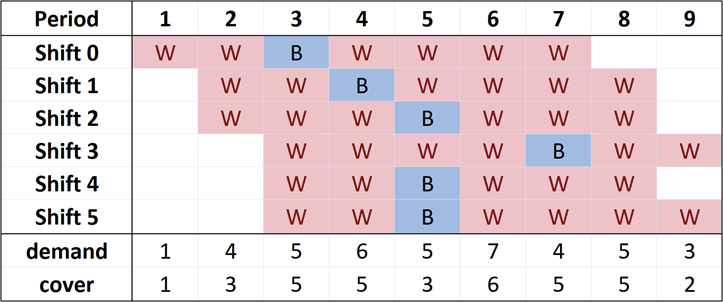

.. we will start with a simple shift scheduling problem and then become more complex
- Variant 1: single activity type, one shift type
- Variant 2: single activity type, two shift types
- Variant 3: multiple activity types, two shift types

We will use a well-known instance set, the "Demassey instances" for multi-activity shift scheduling

## Shift Scheduling, Variant 1

#### Given are:
- the number of planning periods $|P|$ (15 min per period)
- the number of employees / shifts to create $|S|$
- demands per period
- penalties for under- and overcovering
- cost for assigning a period of work

#### The shift creation rules are:
- every work block is at least 1 hour (4 periods) long
- every shift contains a break of 1 period
- every shift contains at least 3 hours of work and (strictly) less than 6 hours of work

#### The objective is to minimize:
- total assignment cost + penalties for under- and overcovering


##  Let us first consider a toy example:


<img src="img/shift_sen_small.png" width="55%" align=right >

On the right: a state-transition graph (SEN) for this toy problem:

- scheduling period: $[0;7]$
- one break of 1 period
- work block length either 2 or three periods
- total work periods <= 5 periods



The state contains the following elements:
- $s^p$: period (time index) (int)
- $s^{nWork}$: numer of periods worked (int)
- $s^{hadBreak}$: did we  have a break? (bool)
- $s^{prevWork}$: prev. assignment was work (bool)

The decisions are **assignments** of work or break blocks




## Shift Scheduling, Variant 1: Defining an instance

In [73]:
class InstanceShift_1(NamedTuple):
    number_of_periods : int
    number_of_employees : int
    min_work_periods : int
    max_work_periods : int
    length_break : int
    min_length_work_block : int
    max_length_work_block : int
    demands : Any
    under_cover_costs : Any
    over_cover_costs : Any
    cost_assignment : int
    

## Shift Scheduling, Variant 1: Reading an instance

...we use a certain well-known instance set from Demassey et. al.:

In [74]:
def read_instance_shift_1(filename):
    with open(filename) as f:
        number_of_periods = int(f.readline())
        max_work_periods_per_shift = int(f.readline())
        number_of_days_in_horizon = int(f.readline())
        is_continous = int(f.readline())
        instance_version = int(f.readline())
        meaningless_parameter = int(f.readline())
        number_of_employees =int(f.readline()[5:])
        skills = ([int(n) for n in f.readline()[:-1].split()])
        number_of_activities = int(f.readline()[4:])

        line_ints = [int(n) for n in f.readline()[:-1].split()]

        min_cons = line_ints[0]
        max_cons = line_ints[1]
        cost_per_activity_assignment = line_ints[2]

        activity_demands = []
        activity_under_cover_costs = []
        activity_over_cover_costs = []

        for act in range(number_of_activities):
            activity_demands.append([int(n) for n in f.readline()[:-1].split()])
            activity_under_cover_costs.append([int(n) for n in f.readline()[:-1].split()])
            activity_over_cover_costs.append([int(n) for n in f.readline()[:-1].split()])
            f.readline()
            f.readline()

    return InstanceShift_1(number_of_periods, number_of_employees, 3*4, 8*4, 1, 4, 6*4, activity_demands[0], activity_under_cover_costs[0], activity_over_cover_costs[0], cost_per_activity_assignment  )

## Creating a generic DP model: Decisions and states

.. in this problem, we define a state as all the information we need to check the shift feasibility:

In [75]:
class StateShift_1(NamedTuple):
    period : int
    periods_worked : int
    had_break : bool
    prev_type : str
        

..and a decision consists in assigning a (multi-period) block of work or break:

In [76]:
class Assignment(NamedTuple):
    start : int
    end : int
    type : str
        

## Creating a generic DP model: Source, sink and start states

- the source and the sink get "dummy states"

- the start states all have "off" as prev_type (will be treated like a break) and 0 periods worked, and no break
- there is one start state for very feasible start period

In [77]:
source_state_shift_1 = StateShift_1(-1, 0, False, "source")
sink_state_shift_1 = StateShift_1(-1, 0 , False, "sink")

def start_states_shift_1(instance):
    
    latest_start_period = instance.number_of_periods - (instance.min_work_periods + instance.length_break)
    
    return [StateShift_1(p, 0, False, "off") for p in range(latest_start_period)]
    
        

## Creating a generic DP model: Feasible decisions

Decisions are **assignments** of either:
- work blocks (there may be multipe work blocks with different lengths starting from a given state)
- break blocks (in case there was no break yet


In [78]:
def get_feasible_decisions_shift_1(instance, state):
    
    assignments = []
    
    ## we add work block arcs
    if state.prev_type in ["off", "break"]:
        for length in range(instance.min_length_work_block, instance.max_length_work_block + 1):

            # do we exceed the planning period?            
            if state.period + length -1 > instance.number_of_periods -1:
                break
                
            if state.periods_worked + length > instance.max_work_periods:
                break                
            
            assignments.append(Assignment(state.period, state.period + length -1, "work"))
            
    elif state.prev_type == "work":
        
        # if we did not have a long break, add one
        if not state.had_break:
            assignments.append(Assignment(state.period, state.period + instance.length_break -1, "break"))
    
    return assignments
            

## Creating a generic DP model: Transition function, cost function, is end state

- a transition function for computing the next state resulting from the assignment and a cost function

- a state is a possible end state if it has two work blocks separated by a break and the number of periods worked is feasible (between the min number of periods worked and the max number of periods worked)



In [79]:
def transition_function_shift_1(instance, state, assignment):
    
    length_assignment = assignment.end - assignment.start + 1
    
    
    if assignment.type == "work":
        return StateShift_1(assignment.end + 1, state.periods_worked + length_assignment, state.had_break, "work" )
    else:
        return StateShift_1(assignment.end + 1, state.periods_worked, True, "break" )
    
def cost_function_shift_1(instance, state, assignment):
    if assignment.type == "work":
        return (assignment.end + 1 - assignment.start) * instance.cost_assignment
    return 0
    
        
def is_possible_end_state_shift_1(instance, state):
    return state.prev_type == "work" and state.had_break and instance.min_work_periods <= state.periods_worked <= instance.max_work_periods
     

    

..and here, the full DP:

In [80]:
dpg_shift_1 = DPG(get_feasible_decisions_shift_1, transition_function_shift_1,  cost_function_shift_1, start_states_shift_1, is_possible_end_state_shift_1, source_state_shift_1, sink_state_shift_1, "min")


## Shift Scheduling, Variant 1: Trying it out: Getting the instance and building the graph




In [81]:

filename_shift = "./../problems/shift_scheduling/instances/shoe_1_1_1_1.txt"
shift_1_instance = read_instance_shift_1(filename_shift)
shift_1_instance.number_of_employees

2

In [82]:
g = build_network_dpg(dpg_shift_1, shift_1_instance)

In [83]:
g.number_of_nodes()

4949

## Shift Scheduling, Variant 1: A MIP model using the DP flow component
$$
   \mathrm{min} \sum_{e \in E}   c_e X_e +  \sum_{p \in P} \bigl( c^\mathrm{o} Y^\mathrm{o}_{p} + c^\mathrm{u} Y^\mathrm{u}_{p} \bigr)
$$

\begin{align} 
  \sum\limits_{e \in v^\mathrm{in}} X_{e} &= \sum\limits_{e \in v^\mathrm{out}} X_{e} &\forall v \in N \qquad  &\text{flow balance} \label{eq:flow_balance} \\
    X_{e^\mathrm{circ}}&=n  \label{eq:total_flow} &\qquad  &\text{fix the numer of employees}\\
  \sum\limits_{e \in E^\mathrm{cov}_{p}} X_{e} + Y^\mathrm{u}_{p} - Y^\mathrm{o}_{p} &= d_{p} &\forall  p \in P \qquad  &\text{demand covering} \label{eq:cover}\\
  X_e &\in \mathbb{Z}^+_0  &\forall e \in E \label{eq:flow_domains} \qquad  & \\ 
  Y^\mathrm{o}_{p} \geq 0, \quad Y^\mathrm{u}_{p} &\geq 0 &\forall p \in P \qquad  &\label{eq:cover_domains}
\end{align}


**Observe:** The demand covering is a soft constraint, and we have two slack variables that are penalized in the objective

## Shift Scheduling, Variant 1: Trying it out: Building the model


..we can re-use the build network flow component stuff

In [84]:
m = gp.Model("Shift_1")

edge_to_flow_var = build_network_flow_component_dpg(m, dpg_shift_1, g, flow_size = shift_1_instance.number_of_employees)

.. now the cover constraints:

In [85]:
## collect the edges covering the periods:
period_cover_vars = [ [] for p in range(shift_1_instance.number_of_periods)]
for e in g.edges(keys=True):
    if type(e[2]) == Assignment and e[2].type == "work":
        for p in range(e[2].start, e[2].end+1):
            period_cover_vars[p].append(edge_to_flow_var[e])
            
## create the under- and overcovering variables and the cover constraints
for p, cover_vars in enumerate(period_cover_vars):
    under_cover_var = m.addVar(vtype=GRB.INTEGER, obj = shift_1_instance.under_cover_costs[p] ) 
    over_cover_var = m.addVar(vtype=GRB.INTEGER, obj = shift_1_instance.over_cover_costs[p] ) 
    
    m.addConstr( gp.quicksum(cover_var for cover_var in cover_vars) + under_cover_var == shift_1_instance.demands[p] + over_cover_var )



## Shift Scheduling, Variant 1: Solving the model



In [86]:
%%time
m.optimize()
m.ObjVal

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5045 rows, 26375 columns and 326290 nonzeros
Model fingerprint: 0x89f17031
Variable types: 0 continuous, 26375 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 4e+02]
  Bounds range     [2e+00, 2e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 3400.0000000
Presolve removed 4357 rows and 20048 columns
Presolve time: 0.21s
Presolved: 688 rows, 6327 columns, 58334 nonzeros
Variable types: 0 continuous, 6327 integer (0 binary)

Root relaxation: objective 7.680000e+02, 358 iterations, 0.01 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

825.0

In [87]:
decompose_flow_to_solution_paths_dpg(edge_to_flow_var, g, dpg_shift_1)

[[Assignment(start=36, end=50, type='work'),
  Assignment(start=51, end=51, type='break'),
  Assignment(start=52, end=55, type='work')],
 [Assignment(start=51, end=57, type='work'),
  Assignment(start=58, end=58, type='break'),
  Assignment(start=59, end=67, type='work')]]

## Shift Scheduling, Variant 2

#### Given are:
- the number of planning periods $|P|$ (15 min per period)
- the number of employees / shifts to create $|S|$
- demands per period
- penalties for under- and overcovering
- cost for assigning a period of work

#### There are two shift types.
- every work block is at least 1 hour (4 periods) long

Shift type 1 (short shift) is defined as in variant 1
- every shift contains a break of 1 period
- every shift contains at least 3 hours of work and (strictly) less than 6 hours of work

Shift type 2 (long shift) is defined as follows:
- every work block is at least 1 hour (4 periods) long
- every shift contains two short breaks of 1 period and one long break of 1 hour (4 periods)
- every shift contains at least 6 hours of work and at most 8 hours of work

#### The objective is to minimize:
- total assignment cost + penalties for under- and overcovering


## Shift Scheduling, Variant 2: Defining an instance

In [88]:
class InstanceShift_2(NamedTuple):
    number_of_periods : int
    number_of_employees : int
    min_work_periods_short : int # new
    min_work_periods_long: int # new
    max_work_periods_short : int # new
    max_work_periods_long : int # new
    length_break_short : int # new
    length_break_long : int # new
    min_length_work_block : int
    max_length_work_block : int
    demands : Any
    under_cover_costs : Any
    over_cover_costs : Any
    cost_assignment : int

## Shift Scheduling, Variant 2: Reading an instance

In [89]:
def read_instance_shift_2(filename):
    with open(filename) as f:
        number_of_periods = int(f.readline())
        max_work_periods_per_shift = int(f.readline())
        number_of_days_in_horizon = int(f.readline())
        is_continous = int(f.readline())
        instance_version = int(f.readline())
        meaningless_parameter = int(f.readline())
        number_of_employees =int(f.readline()[5:])
        skills = ([int(n) for n in f.readline()[:-1].split()])
        number_of_activities = int(f.readline()[4:])

        line_ints = [int(n) for n in f.readline()[:-1].split()]

        min_cons = line_ints[0]
        max_cons = line_ints[1]
        cost_per_activity_assignment = line_ints[2]

        activity_demands = []
        activity_under_cover_costs = []
        activity_over_cover_costs = []

        for act in range(number_of_activities):
            activity_demands.append([int(n) for n in f.readline()[:-1].split()])
            activity_under_cover_costs.append([int(n) for n in f.readline()[:-1].split()])
            activity_over_cover_costs.append([int(n) for n in f.readline()[:-1].split()])
            f.readline()
            f.readline()

    return InstanceShift_2(number_of_periods, number_of_employees, 3*4, 6*4, 6*4-1, 8*4, 1, 4, 4, 6*4, activity_demands[0], activity_under_cover_costs[0], activity_over_cover_costs[0], cost_per_activity_assignment  )

In [90]:
filename_shift = "./../problems/shift_scheduling/instances/shoe_1_1_1_1.txt"
shift_2_instance = read_instance_shift_2(filename_shift)


## Shift Scheduling, Variant 2: Defining the state and source, sink and start states
.. assignment object stays the same

but we augment the state variable by:

- had_long_break
- number_of_short_breaks

Observe: using the augmented state information, we can distinguish short and long shifts:
- we automatically have a long shift if we had one long break
- we have a short shift if we have a single short break



In [91]:
class StateShift_2(NamedTuple):
    period : int
    periods_worked : int
    number_short_breaks : int # new
    had_long_break : bool # new
    prev_type : str

..source and sink state

In [92]:
source_state_shift_2 = StateShift_2(-1, 0, 0, False, "source")
sink_state_shift_2 = StateShift_2(-1, 0, 0, False, "sink")


..start states

In [99]:
def start_states_shift_2(instance):
    
    latest_start_period = instance.number_of_periods - (instance.min_work_periods_short + instance.length_break_short +1)
    
    return [StateShift_2(p, 0, 0, False, "off") for p in range(latest_start_period)]
    
        

## Creating a generic DP model: Feasible decisions
- now, we have more break options!

In [100]:
def get_feasible_decisions_shift_2(instance, state):
    
    assignments = []
    
    ## we add work block arcs
    if state.prev_type in ["off", "break"]:
        for length in range(instance.min_length_work_block, instance.max_length_work_block+1):
            
            # do we exceed the planning period?            
            if state.period + length -1 > instance.number_of_periods -1:
                break
            
            ## maximum work periods            
            if state.periods_worked + length > instance.max_work_periods_long:
                break            

            assignments.append(Assignment(state.period, state.period + length -1, "work"))
            
    elif state.prev_type == "work":        
        # if we did not have a long break, add one
        if not state.had_long_break:
            assignments.append(Assignment(state.period, state.period + instance.length_break_long -1, "break_long"))
            
        # if we did not have a long break, add one
        if state.number_short_breaks < 2:
            assignments.append(Assignment(state.period, state.period + instance.length_break_short -1, "break_short"))
            
    return assignments


     

## Creating a generic DP model: Transition function, cost function, is end state

- for the possible end states, we now need to recognize if we are in a short or long shift and check the 

In [101]:
def transition_function_shift_2(instance, state, assignment):
    
    length_assignment = assignment.end - assignment.start +1
    
    if assignment.type == "work":
        return StateShift_2(assignment.end + 1, state.periods_worked + length_assignment, state.number_short_breaks, state.had_long_break, "work" )
    
    elif assignment.type == "break_short":
        return StateShift_2(assignment.end + 1, state.periods_worked, state.number_short_breaks +1, state.had_long_break, "break" )
    
    else: # assignment.type == "break_long":
        return StateShift_2(assignment.end + 1, state.periods_worked, state.number_short_breaks, True, "break" )
   

def cost_function_shift_2(instance, state, assignment):
    if assignment.type == "work":
        return (assignment.end + 1 - assignment.start) * instance.cost_assignment
    return 0   
        

def is_possible_end_state_shift_2(instance, state):
    
    if not state.prev_type == "work":
        return False
    
    # check if feasible long shift
    if state.had_long_break:    
        return (state.number_short_breaks == 2) and ( instance.min_work_periods_long <= state.periods_worked <= instance.max_work_periods_long )
        
    else:
        return (state.number_short_breaks == 1) and ( instance.min_work_periods_short <= state.periods_worked <= instance.max_work_periods_short )
        
    

..and now, the full dpg object

In [102]:
dpg_shift_2 = DPG(get_feasible_decisions_shift_2, transition_function_shift_2,  cost_function_shift_2, start_states_shift_2, is_possible_end_state_shift_2, source_state_shift_2, sink_state_shift_2, "min")

## Shift Scheduling, Variant 2: Trying it out: Getting the instance and building the graph


In [103]:
filename_shift = "./../problems/shift_scheduling/instances/shoe_1_1_1_1.txt"
shift_2_instance = read_instance_shift_2(filename_shift)
shift_2_instance.number_of_employees

2

..building the graph

In [104]:
g = build_network_dpg(dpg_shift_2, shift_2_instance)

In [105]:
g.number_of_nodes()

16355

## Shift Scheduling, Variant 2: Building the mathematical model



In [106]:
m = gp.Model("shift_2")

edge_to_flow_var = build_network_flow_component_dpg(m, dpg_shift_2, g, flow_size = shift_2_instance.number_of_employees)

...cover constraints

In [107]:
## collect the edges covering the periods

period_cover_vars = [ [] for p in range(shift_2_instance.number_of_periods)]

for e in g.edges(keys=True):
    if type(e[2]) == Assignment and e[2].type == "work":
        for p in range(e[2].start, e[2].end+1):
            period_cover_vars[p].append(edge_to_flow_var[e])            

## create the under- and overcovering variables and the cover constraints
for p, cover_vars in enumerate(period_cover_vars):
    under_cover_var = m.addVar(vtype=GRB.INTEGER, obj = shift_2_instance.under_cover_costs[p] ) 
    over_cover_var = m.addVar(vtype=GRB.INTEGER, obj = shift_2_instance.over_cover_costs[p] ) 
    
    m.addConstr( gp.quicksum(cover_var for cover_var in cover_vars) + under_cover_var == shift_2_instance.demands[p] + over_cover_var )



## Shift Scheduling, Variant 2: Solving the model

In [108]:
%%time
m.optimize()

m.ObjVal

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16451 rows, 95416 columns and 1116927 nonzeros
Model fingerprint: 0x4007c32f
Variable types: 0 continuous, 95416 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 4e+02]
  Bounds range     [2e+00, 2e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 6160.0000000
Presolve removed 14363 rows and 76364 columns
Presolve time: 0.74s
Presolved: 2088 rows, 19052 columns, 162340 nonzeros
Found heuristic solution: objective 3400.0000000
Variable types: 0 continuous, 19052 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with primal simplex

Root relaxation: 

825.0

In [109]:
decompose_flow_to_solution_paths_dpg(edge_to_flow_var, g, dpg_shift_2)

[[Assignment(start=36, end=50, type='work'),
  Assignment(start=51, end=51, type='break_short'),
  Assignment(start=52, end=55, type='work')],
 [Assignment(start=51, end=56, type='work'),
  Assignment(start=57, end=57, type='break_short'),
  Assignment(start=58, end=67, type='work')]]

## Shift Scheduling, Variant 3: Two shift types, multiple activities

So far, we do have a model for a single-activity problem.

- now we consider different types of demand / activity types
- every employee can cover every activity type
- every block of work consists of a single activity type


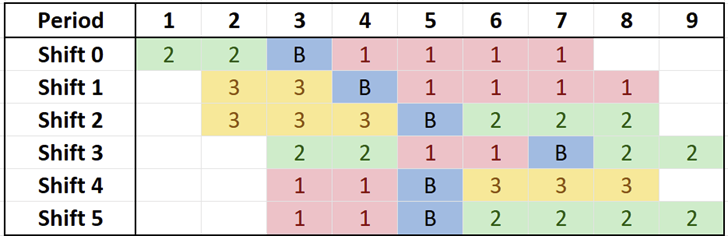


- how can we change our model to adapt to this setting?

## Shift Scheduling, Variant 3: Defining an instance

In [110]:
class InstanceShift_3(NamedTuple):
    number_of_periods : int
    number_of_employees : int
    number_of_activities : int
    min_work_periods_short : int # new
    min_work_periods_long: int # new
    max_work_periods_short : int # new
    max_work_periods_long : int # new
    length_break_short : int # new
    length_break_long : int # new
    min_length_work_block : int
    max_length_work_block : int
    activity_demands : Any
    activity_under_cover_costs : Any
    activity_over_cover_costs : Any
    cost_assignment : int

## Shift Scheduling, Variant 3: Reading an instance

In [111]:
def read_instance_shift_3(filename):
    with open(filename) as f:
        number_of_periods = int(f.readline())
        max_work_periods_per_shift = int(f.readline())
        number_of_days_in_horizon = int(f.readline())
        is_continous = int(f.readline())
        instance_version = int(f.readline())
        meaningless_parameter = int(f.readline())
        number_of_employees =int(f.readline()[5:])
        skills = ([int(n) for n in f.readline()[:-1].split()])
        number_of_activities = int(f.readline()[4:])

        line_ints = [int(n) for n in f.readline()[:-1].split()]

        min_cons = line_ints[0]
        max_cons = line_ints[1]
        cost_per_activity_assignment = line_ints[2]

        activity_demands = []
        activity_under_cover_costs = []
        activity_over_cover_costs = []

        for act in range(number_of_activities):
            activity_demands.append([int(n) for n in f.readline()[:-1].split()])
            activity_under_cover_costs.append([int(n) for n in f.readline()[:-1].split()])
            activity_over_cover_costs.append([int(n) for n in f.readline()[:-1].split()])
            f.readline()
            f.readline()

    return InstanceShift_3(number_of_periods, number_of_employees, number_of_activities, 3*4, 6*4, 6*4-1, 8*4, 1, 4, 4, 6*4, activity_demands, activity_under_cover_costs, activity_over_cover_costs, cost_per_activity_assignment  )

In [112]:
filename_shift = "./../problems/shift_scheduling/instances/shoe_1_2_1_1.txt"
shift_3_instance = read_instance_shift_3(filename_shift)
shift_3_instance.number_of_activities

2

## Shift Scheduling, Variant 3: A key modeling idea: Template Blocks

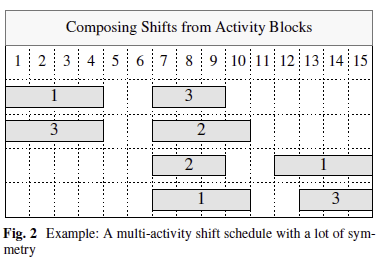

## Shift Scheduling, Variant 3: A key modeling idea: Template Blocks
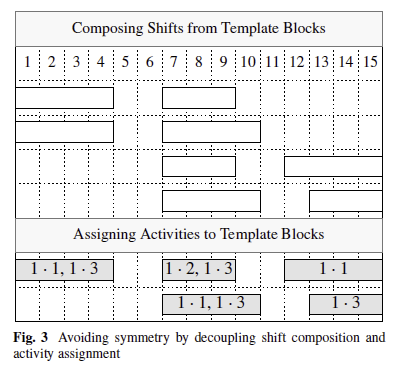

## The template block approach in more detail

**Observe:**
- each work block arises in several arcs in the network
- separating each of them by activity introduces lots of symmetry

**Model idea**
- build a single-activity model and consider those work assignements as "template blocks"
- then make sure that  block $b$ (defined by start- and end-time), the number of "activity-specific" blocks used for covering the activity-specific demand equals the total size of the  flow through an edge representing $b$ in the "template network"


\begin{align} 
    \sum\limits_{e \in E^{\mathrm{\square}}_{b}} X_{e} = \sum\limits_{a \in A^b}  &X^\square_{b,a}  &\forall b \in B_{\square}  \\
      \sum\limits_{b \in B^\mathrm{cov}_{a,p}} X^\square_{b,a} + Y^\mathrm{u}_{a,p} - Y^\mathrm{o}_{a,p} &= d_{a,p} &\forall a \in A, p \in P \label{eq:cover-activity-blocks} \\
  X^{\square}_{b,a}  &\in \mathbb{Z}^{+}_{0} &\forall a \in A, B \in B_a  \label{eq:activity_block_domain}
\end{align}

## Building the model: Single-Activity flow

- create the single-activity flow

In [113]:
g = build_network_dpg(dpg_shift_2, shift_3_instance)

In [114]:
m=gp.Model("shift_3")

edge_to_flow_var = build_network_flow_component_dpg(m, dpg_shift_2, g, flow_size = shift_2_instance.number_of_employees)

## Building the model: The additional constraints


In [115]:
## cover constraints

#collect work blocks
work_block_to_vars = dict()

for e in g.edges(keys=True):
    if type(e[2]) == Assignment and e[2].type == "work":
        if e[2] not in work_block_to_vars:
            work_block_to_vars[e[2]] = []
        work_block_to_vars[e[2]].append(edge_to_flow_var[e])
 

## create activity blocks for each work block

activity_period_cover_vars = []

for activity in range(shift_3_instance.number_of_activities):
    activity_period_cover_vars.append([])
    for p in range(shift_3_instance.number_of_periods):
        activity_period_cover_vars[activity].append([])

for work_block, work_block_variables in work_block_to_vars.items():
    act_block_vars =[]
    for a in range(shift_3_instance.number_of_activities):

        act_block_var = m.addVar(vtype=GRB.INTEGER)
        act_block_vars.append(act_block_var)     
        
        for p in range(work_block.start, work_block.end+1):
            activity_period_cover_vars[a][p].append(act_block_var)
            
        m.addConstr(gp.quicksum(act_block_var for act_block_var in act_block_vars) == gp.quicksum( work_block_var for work_block_var in work_block_variables  ))


for a in range(shift_3_instance.number_of_activities):      

    for p, cover_vars in enumerate(activity_period_cover_vars[a]):
        under_cover_var = m.addVar(vtype=GRB.INTEGER, obj = shift_3_instance.activity_under_cover_costs[a][p] ) 
        over_cover_var = m.addVar(vtype=GRB.INTEGER, obj = shift_3_instance.activity_over_cover_costs[a][p] ) 

        m.addConstr(gp.quicksum(cover_var for cover_var in cover_vars) + under_cover_var == shift_3_instance.activity_demands[a][p] + over_cover_var)


## Solving the model


In [116]:

m.optimize()
m.objVal

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 20033 rows, 99094 columns and 410723 nonzeros
Model fingerprint: 0xa18977b7
Variable types: 0 continuous, 99094 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 4e+02]
  Bounds range     [2e+00, 2e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 18080 rows and 75929 columns
Presolve time: 0.45s
Presolved: 1953 rows, 23165 columns, 65852 nonzeros
Variable types: 0 continuous, 23165 integer (0 binary)
Found heuristic solution: objective 7280.0000000

Root relaxation: objective 1.770000e+03, 4709 iterations, 0.75 seconds (1.65 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

1770.0

### Getting a solution
- now, extracting a solution is a bit more intricate:
  - if we decompose the flow, we only get the work blocks
  - then, we need to assign every work block an activity block
  
.. we do not show this here..

## Wrapping up

- DP models are a (surprisingly?) versatile tool in combinatorial optimization
- as part of MIP models, they can form the basis for highly efficient (extended) formulations
- they also open a whole field of research topic that exploits their structure and benefits from combining different areas of research 

## Projects

Ideally...
- you form groups of 2-3 students
- both the project involves aspects from this course with aspects of your own research
- the project leads to a publication project

As a starting point, I proposetwo projects 
- from the field of personnel scheduling 
- for which we have existing papers
- and open instances
- where I feel using the approaches can lead to new best known or even (unknown) optimal solutions


## Project Proposal I

#### Multi-Activity, Multi-Day Shift Scheduling 

- Problem Description: https://www.schedulingbenchmarks.org/matsp/ProblemDefinition.pdf
- Paper proposing a Variable Neigborhood Search: https://nrl.northumbria.ac.uk/id/eprint/43314/1/ICORES_2020_42.pdf
- Instances and best known solutions: https://www.schedulingbenchmarks.org/matsp/

## Project Proposal II

#### The shift design and break scheduling problem
- Problem description, instances and best-known solutions: https://www.dbai.tuwien.ac.at/proj/SoftNet/Supervision/Benchmarks/
- A (heuristic) two stage ILP Solution approach (Annals of OR): https://link.springer.com/article/10.1007/s10479-019-03487-6
- A sub-problem is the shift design problem, which can be also tackled using our approaches (but: for this sub-problem,all instances already closed, I think)